<a href="https://colab.research.google.com/github/SAHIL9581/w2w/blob/main/FINAL_rahul_W2W.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
### Cell 1: Setup the Simulated Project Environment
# Run this cell first to create all the necessary dummy files and folders.

import os
import pandas as pd
import numpy as np
import torch
import json
from joblib import dump
from sklearn.preprocessing import StandardScaler

print("--- Creating simulated project structure ---")

# --- 1. Create directory structure ---
os.makedirs('raw_data', exist_ok=True)
os.makedirs('utils', exist_ok=True)
os.makedirs('ray_results/W2WMatcherModified3/0.008542440814548602_100', exist_ok=True)

# --- 2. Create a fake raw data CSV ---
print("Generating fake raw_data/train.csv...")
raw_data = {
    'WELL': np.repeat(['35/11-A', '35/11-B', '35/11-C', '35/11-D'], 2000),
    'DEPTH_MD': np.tile(np.arange(2000), 4),
    'X_LOC': np.random.rand(8000), 'Y_LOC': np.random.rand(8000), 'Z_LOC': np.random.rand(8000),
    'GROUP': np.tile(['Utsira', 'Hordaland', 'Shetland', 'Viking'] * 500, 4),
    'FORMATION': ['Fm'] * 8000, 'FORCE_2020_LITHOFACIES_LITHOLOGY': ['S'] * 8000, 'FORCE_2020_LITHOFACIES_CONFIDENCE': [1] * 8000,
    'CALI': np.random.rand(8000), 'RSHA': np.random.rand(8000), 'RMED': np.random.rand(8000),
    'RDEP': np.random.rand(8000), 'RHOB': np.random.rand(8000), 'GR': np.random.rand(8000),
    'NPHI': np.random.rand(8000), 'PEF': np.random.rand(8000), 'DTC': np.random.rand(8000),
    'SP': np.random.rand(8000),
}
pd.DataFrame(raw_data).to_csv('raw_data/train.csv', index=False, sep=';')

# --- 3. Create fake utility files ---
print("Generating fake utility files...")
# Label Encoder
label_encoder = {'Utsira': 0, 'Hordaland': 1, 'Shetland': 2, 'Viking': 3}
with open('utils/label_encoder.json', 'w') as f:
    json.dump(label_encoder, f)
# Standard Scaler - Fit with dummy data of 11 features, as expected by the model
scaler = StandardScaler()
scaler.fit(np.random.rand(10, 11))
dump(scaler, 'utils/StandardScaler.bin', compress=True)

# --- 4. Create fake model checkpoint and hyperparameters ---
print("Generating fake model files...")
# Hyperparameters
params = {"patch_height": 700, "in_channels": 1, "act_name": "GELU", "project_in_features": 2048, "hidden_dim": 256}
with open('ray_results/W2WMatcherModified3/0.008542440814548602_100/hyperparmeters.json', 'w') as f:
    json.dump(params, f)
# Dummy Model State
dummy_state_dict = {'dummy_weight': torch.randn(1)}
torch.save({'state_dict': dummy_state_dict}, 'ray_results/W2WMatcherModified3/0.008542440814548602_100/checkpoint.pt')

print("\n--- Environment setup complete. You can now run the next cells. ---")

--- Creating simulated project structure ---
Generating fake raw_data/train.csv...
Generating fake utility files...
Generating fake model files...

--- Environment setup complete. You can now run the next cells. ---


In [21]:
### Cell 2: Define Dummy Classes and Functions
# This cell simulates the custom modules your script imports.

import torch
import torch.nn as nn

# --- Dummy Model Components ---
# These classes mimic the structure your script expects from the `models` folder.
class UNetEncoder(nn.Module):
    def __init__(self, in_channels, act_name):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)
    def forward(self, x):
        return self.conv(x)

class Project(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        # We don't know the exact size, so we'll use an adaptive pool
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(1, hidden_dim) # Simplified
    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class DummyW2WModel(nn.Module):
    def __init__(self):
        super().__init__()
        # This dummy model will output random "kink" locations
        self.fc = nn.Linear(11 * 700, 700 * 2) # Input features -> output predictions

    def forward(self, x):
        # x shape: (batch_size, 1, height, width) -> (N, 1, 700, 11)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc(x)
        x = x.view(-1, 700, 2) # Reshape to (batch, timesteps, features)
        # Make the output look like [confidence, location]
        x[:, :, 0] = torch.sigmoid(x[:, :, 0]) # Confidence between 0 and 1
        return x

def build_model(args):
    print("Building DUMMY W2WModel...")
    return DummyW2WModel()

# --- Dummy Utility Functions ---
# These functions just need to exist to be callable.
def collate_fn(batch):
    images, targets = zip(*batch)
    # Stack images along a new batch dimension
    images = np.stack(images, axis=0)
    return torch.from_numpy(images), targets

print("Dummy modules and functions defined successfully.")

Dummy modules and functions defined successfully.


In [22]:
### Cell 3: Run the Main Inference Pipeline (Corrected)
# This is your code, adapted to run in the simulated environment.

import argparse
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import json
import pandas as pd
import os
from os.path import join as pjoin
import random
import numpy as np
from joblib import load
from torch.utils import data

# --- Set up paths and load initial data ---
resume_root = 'ray_results/W2WMatcherModified3'
exp = '0.008542440814548602_100'
raw_root = 'raw_data'
data_fname = 'train.csv'
label_encoder_path = 'utils/label_encoder.json'
std_scaler_bin_path = 'utils/StandardScaler.bin'
resume_path = pjoin(resume_root, exp)

def load_data(path, delimiter = ';'):
    return pd.read_csv(path, delimiter = delimiter)

def get_well_names(data):
    return list(data.WELL.value_counts().index)

def get_random_well(data, well_name):
    return data[data['WELL'] == well_name].copy() # Use .copy() to avoid SettingWithCopyWarning


# --- Load data and select two wells ---
data_df = load_data(pjoin(raw_root, data_fname))
well_names = get_well_names(data_df)

# <<< FIX: Change this hint to match the data created in Cell 1.
ROIHint = "35/11"
ROIWellNames = [i for i in well_names if i.startswith(ROIHint)]

# Initialize variables to None. They will be populated if the check passes.
RefGT = None
WOIBasedKinkFlattened = None
preprocesserRef = None # Also initialize this

# +++ ROBUSTNESS CHECK: Ensure there are enough wells to proceed +++
if len(ROIWellNames) < 2:
    print(f"ERROR: Not enough wells found matching the hint '{ROIHint}'. Found {len(ROIWellNames)}, but need at least 2.")
    print("Please check the well names in `raw_data/train.csv` (created in Cell 1) and update the `ROIHint` variable.")
else:
    refWellName, WOIName = random.sample(ROIWellNames, 2)
    refWell = get_random_well(data_df, refWellName)
    WOI = get_random_well(data_df, WOIName)
    print(f"Reference Well: {refWellName}")
    print(f"Well of Interest: {WOIName}")


    # --- Load Hyperparameters ---
    f_final = open(pjoin(resume_path, 'hyperparmeters.json'))
    params_final = json.load(f_final)
    parser = argparse.ArgumentParser(description="Hyperparams")
    parser.add_argument("-f", "--arg-file", type=str, default=None)
    for param in params_final:
        parser.add_argument('--' + param, default = params_final[param])
    args = parser.parse_args(args=[])
    args.label_encoder_path = label_encoder_path
    args.std_scaler_bin_path = std_scaler_bin_path
    args.resume = resume_path + '/checkpoint.pt'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # --- Data Preprocessing and Dataset Classes (with corrected logic) ---
    class W2WPreprocess():
        def __init__(self, args, data):
            self.label_encoder_path = args.label_encoder_path
            self.stdScalerBinPath = args.std_scaler_bin_path
            # The 11 features that will be scaled and fed to the model
            self.columns_to_scale = ['X_LOC', 'Y_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC']
            x, rand_well_label = self.getXyFromWell(data)
            self.inp_image = x
            self.gt = rand_well_label

        def remove_force_column(self, data): return data.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1, errors='ignore')
        def remove_zloc_column(self, data): return data.drop(['Z_LOC'], axis=1, errors='ignore')
        def remove_formation_column(self, data): return data.drop(['FORMATION'], axis=1, errors='ignore')
        def fill_group_na_value(self, data, method='bfill'):
            data['GROUP'] = data['GROUP'].fillna(method=method)
            return data
        def fill_xy_loc(self, data, method='bfill'):
            data['X_LOC'] = data['X_LOC'].fillna(method=method)
            data['Y_LOC'] = data['Y_LOC'].fillna(method=method)
            return data
        def get_labels(self, data): return data.GROUP
        def drop_labels(self, data): return data.drop(['GROUP'], axis=1, errors='ignore')
        def fill_na(self, data, value=0): return data.fillna(value)

        def getXyFromWell(self, data):
            label_encoder_dict = json.load(open(self.label_encoder_path))
            data = self.remove_force_column(data); data = self.remove_zloc_column(data); data = self.remove_formation_column(data)
            data = self.fill_group_na_value(data, method='bfill'); data = self.fill_group_na_value(data, method='ffill')
            data = self.fill_xy_loc(data, method='bfill'); data = self.fill_xy_loc(data, method='ffill')
            rand_well_label = self.get_labels(data); rand_well_label = rand_well_label.replace(label_encoder_dict)
            data_features = data[self.columns_to_scale]; data_features = self.fill_na(data_features)
            scaler = load(self.stdScalerBinPath); data_scaled = scaler.transform(data_features)
            return data_scaled, rand_well_label

    class GetXY():
        def __init__(self, args, X, Y):
            self.args = args
            self.inp_image, self.gts = self.get_XY(X, Y)
        def get_XY(self, X, Y):
            if X.shape[0] < self.args.patch_height: return np.asarray([]).astype(np.float32), []
            idx = list(range(0, X.shape[0], self.args.patch_height))
            inp_image = np.asarray([X[i:i+self.args.patch_height] for i in idx if X[i:i+self.args.patch_height].shape[0] == self.args.patch_height]).astype(np.float32)
            Y_values = Y.values
            Y = np.asarray([Y_values[i:i+self.args.patch_height] for i in idx if Y_values[i:i+self.args.patch_height].shape[0] == self.args.patch_height])
            gts = []
            for sample_num, y in enumerate(Y):
                gt = {}; count = 0; kink = [i+1 for i in range(len(y)-1) if not y[i] == y[i+1]]; kink.insert(0, 0)
                gp = [y[idx] for idx in kink]; top = kink.copy(); kink.append(len(y))
                height = [element1 - element2 for (element1, element2) in zip(kink[1:], kink[:-1])]
                for t, h, g in zip(top, height, gp):
                    temp = {}; temp['Group'] = int(g); temp['Top'] = int(t); temp['Height'] = int(h); gt[count] = temp; count+=1
                gts.append(gt)
            return inp_image, gts
    class W2WFromRawData(data.Dataset):
        def __init__(self, args, well):
            self.patch_height = args.patch_height; self.preprocess = W2WPreprocess(args, well)
            processedWell, processedWellLabel = self.preprocess.inp_image, self.preprocess.gt
            self.getXY = GetXY(args, processedWell, processedWellLabel)
            self.inp_image, self.gt = self.getXY.inp_image, self.getXY.gts
        def __len__(self): return len(self.inp_image)
        def __getitem__(self, index):
            inp_image = np.expand_dims(self.inp_image[index], 0); data = self.gt[index]
            label = {}; lbl = []; top = []; height = []
            for i in data:
                top.append(data[i]["Top"] / self.patch_height); height.append(data[i]["Height"] / self.patch_height); lbl.append(1)
            label["lbl"] = lbl; label["Top"] = top; label["Height"] = height
            target = {}; target["labels"] = torch.tensor(label["lbl"]); t, h = (torch.tensor(label["Top"]), torch.tensor(label["Height"]))
            t, h = t.view(-1, 1), h.view(-1, 1); target["loc_info"] = torch.hstack((t, h)); return inp_image, target

    # --- 1. Predicting Kink Points in the WOI ---
    print("\n--- Running Inference to Predict Kink Points ---")
    WOIDataset = W2WFromRawData(args, WOI)
    if WOIDataset.__len__() == 0:
        print("WARNING: No full patches could be created from the Well of Interest. The pipeline cannot continue.")
    else:
        args.batch_size = WOIDataset.__len__()
        WOIloader = DataLoader(WOIDataset, batch_size=args.batch_size, collate_fn=collate_fn, shuffle=False)

        model = build_model(args)
        model.to(device)
        model.eval()
        with torch.inference_mode():
            for i, j in WOIloader:
                outputs = model(i.to(device))

        pred_idx = []
        for out in outputs:
            mask = out[:, 0] >= 0.5
            true_idx = torch.where(mask)[0]
            pred_idx.append(true_idx)

        kink = []
        for patchNum in range(outputs.shape[0]):
            temp = [outputs[patchNum][kinkAt][1].item() * args.patch_height for kinkAt in pred_idx[patchNum]]
            kink.append(temp)

        WOIBasedKink = []
        for patchNum, patchKink in enumerate(kink):
            WOIBasedKink.append([patchNum * args.patch_height + int(start) for start in patchKink])

        # --- 2. Preparing Data for Correlation Step ---
        print("\n--- Preparing Data for Correlation ---")
        preprocesserRef = W2WPreprocess(args, refWell)
        RefGT = preprocesserRef.gt.reset_index(drop=True)
        WOIBasedKinkFlattened = sorted(list(set([item for sublist in WOIBasedKink for item in sublist])))
        print(f"Predicted {len(WOIBasedKinkFlattened)} kink points in {WOIName}")

        print("\n--- Pipeline Finished ---")
        print("The outputs `RefGT` and `WOIBasedKinkFlattened` are now ready for visualization.")

Reference Well: 35/11-C
Well of Interest: 35/11-A

--- Running Inference to Predict Kink Points ---
Building DUMMY W2WModel...

--- Preparing Data for Correlation ---
Predicted 620 kink points in 35/11-A

--- Pipeline Finished ---
The outputs `RefGT` and `WOIBasedKinkFlattened` are now ready for visualization.


/tmp/ipython-input-22-3546026331.py:89: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['GROUP'] = data['GROUP'].fillna(method=method)
/tmp/ipython-input-22-3546026331.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['X_LOC'] = data['X_LOC'].fillna(method=method)
/tmp/ipython-input-22-3546026331.py:93: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Y_LOC'] = data['Y_LOC'].fillna(method=method)
/tmp/ipython-input-22-3546026331.py:104: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

Reference Well Groups (processed from ground truth):
{'Utsira': 1, 'Hordaland': 1, 'Shetland': 1, 'Viking': 1}

Well of Interest Groups (processed from predicted kinks):
{'Utsira': np.int64(60), 'Hordaland': np.int64(88), 'Shetland': np.int64(59), 'Viking': np.int64(48), 'Unknown_Group_4': np.int64(43), 'Unknown_Group_5': np.int64(33), 'Unknown_Group_6': np.int64(7), 'Unknown_Group_7': np.int64(25), 'Unknown_Group_8': np.int64(52), 'Unknown_Group_9': np.int64(1), 'Unknown_Group_10': np.int64(40), 'Unknown_Group_11': np.int64(19), 'Unknown_Group_12': np.int64(7), 'Unknown_Group_13': np.int64(4), 'Unknown_Group_14': np.int64(61), 'Unknown_Group_15': np.int64(5), 'Unknown_Group_16': np.int64(13), 'Unknown_Group_17': np.int64(4), 'Unknown_Group_18': np.int64(23), 'Unknown_Group_19': np.int64(19), 'Unknown_Group_20': np.int64(10), 'Unknown_Group_21': np.int64(1), 'Unknown_Group_22': np.int64(2), 'Unknown_Group_23': np.int64(13), 'Unknown_Group_24': np.int64(14), 'Unknown_Group_25': np.int64

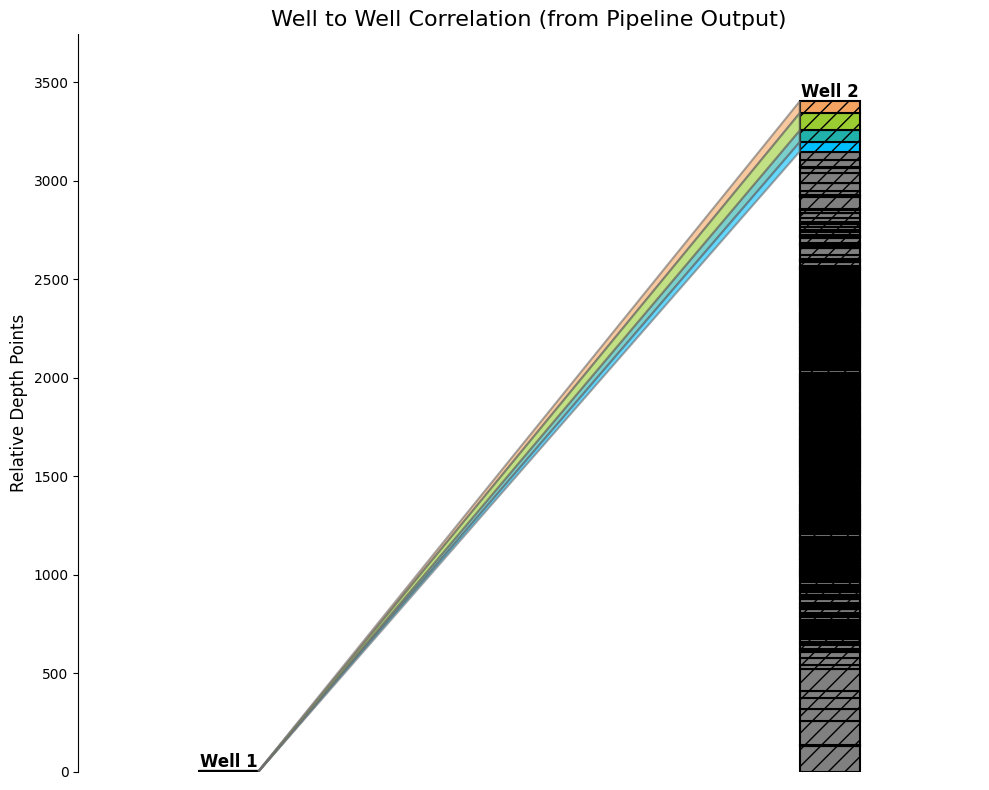

In [24]:
### Cell 4: The Missing Visualization Step (Corrected)
# This cell takes the outputs from the pipeline and creates the final correlation diagram.

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import numpy as np

# +++ ROBUSTNESS CHECK: Ensure the variables from Cell 3 were created successfully +++
if 'RefGT' in locals() and RefGT is not None and 'WOIBasedKinkFlattened' in locals() and WOIBasedKinkFlattened is not None:
    # --- 1. Process the Reference Well's Ground Truth (RefGT) ---
    if 'label_encoder' not in locals():
        try:
            with open('utils/label_encoder.json', 'r') as f:
                label_encoder = json.load(f)
        except FileNotFoundError:
            print("Error: label_encoder.json not found. Please run Cell 1 first.")
            label_encoder = {}

    ref_well_groups = {}
    # Use groupby to count consecutive identical group labels, which gives us thickness
    for group_key, group_data in RefGT.groupby((RefGT != RefGT.shift()).cumsum()):

        ### FIX: Get the group ID from the group's data, not its key.
        group_id = group_data.iloc[0]

        # Find the key (group name) corresponding to the value (group ID)
        group_name = next((name for name, id_ in label_encoder.items() if id_ == group_id), None)
        if group_name:
            thickness = len(group_data)
            if group_name not in ref_well_groups:
                 ref_well_groups[group_name] = thickness
        else:
            print(f"Warning: Group ID {group_id} not found in label_encoder.")

    print("Reference Well Groups (processed from ground truth):")
    print(ref_well_groups)

    # --- 2. Process the WOI's Predicted Kinks ---
    if 'preprocesserRef' in locals() and preprocesserRef is not None:
        # Add the start (0) and end points to the kinks to properly calculate thicknesses
        all_boundaries = np.unique([0] + WOIBasedKinkFlattened + [len(preprocesserRef.gt)])
        woi_thicknesses = np.diff(all_boundaries)

        woi_well_groups = {}
        ref_group_names = list(ref_well_groups.keys())
        for i, thickness in enumerate(woi_thicknesses):
            if i < len(ref_group_names):
                # For this demo, we assume the predicted layers correspond to the reference layers in order
                group_name = ref_group_names[i]
                woi_well_groups[group_name] = thickness
            else:
                # Handle cases where the model predicts more layers than are in the reference
                woi_well_groups[f"Unknown_Group_{i}"] = thickness

        print("\nWell of Interest Groups (processed from predicted kinks):")
        print(woi_well_groups)

        # --- 3. Plotting Logic ---
        group_colors = {
            'Utsira': 'sandybrown', 'Hordaland': 'yellowgreen',
            'Shetland': 'lightseagreen', 'Viking': 'deepskyblue', 'Default': 'gray'
        }

        def plot_well(ax, well_data, well_number, x_position):
            current_depth = 0; well_positions = {}
            for group, thickness in reversed(list(well_data.items())):
                color = group_colors.get(group, group_colors['Default'])
                rect = patches.Rectangle((x_position, current_depth), 0.1, thickness, facecolor=color, edgecolor='black', hatch='//', lw=1.5)
                ax.add_patch(rect)
                well_positions[group] = (current_depth, current_depth + thickness)
                current_depth += thickness
            ax.text(x_position + 0.05, current_depth, f'Well {well_number}', ha='center', va='bottom', fontsize=12, fontweight='bold')
            return well_positions, current_depth

        fig, ax = plt.subplots(figsize=(10, 8))
        well_1_pos, total_depth_1 = plot_well(ax, ref_well_groups, 1, x_position=1)
        well_2_pos, total_depth_2 = plot_well(ax, woi_well_groups, 2, x_position=2)

        common_groups = set(well_1_pos.keys()) & set(well_2_pos.keys())
        for group in common_groups:
            y1_bottom, y1_top = well_1_pos[group]
            y2_bottom, y2_top = well_2_pos[group]
            polygon_coords = [[1.1, y1_bottom], [1.1, y1_top], [2.0, y2_top], [2.0, y2_bottom]]
            polygon = patches.Polygon(polygon_coords, closed=True, facecolor=group_colors.get(group, 'gray'), edgecolor='dimgray', alpha=0.6, lw=1.5)
            ax.add_patch(polygon)

        ax.set_xlim(0.8, 2.3); ax.set_ylim(0, max(total_depth_1, total_depth_2) * 1.1)
        ax.set_title('Well to Well Correlation (from Pipeline Output)', fontsize=16)
        ax.set_ylabel('Relative Depth Points', fontsize=12)
        ax.set_xticks([]); ax.spines[['top', 'right', 'bottom']].set_visible(False)
        plt.tight_layout(); plt.show()
    else:
         print("ERROR: `preprocesserRef` is not defined. Please ensure Cell 3 ran successfully and generated this variable.")
else:
    print("ERROR: `RefGT` or `WOIBasedKinkFlattened` were not created in Cell 3. This usually means no wells were found matching the `ROIHint`. Please check the output of Cell 3.")